In [ ]:
import os
from pathlib import Path
import cv2
import numpy as np


from google.colab import drive
drive.mount('/content/drive')

image_query = "/content/drive/MyDrive/Master-Thesis-Structure-from-Motion/registration/Capture2.PNG"
image_target = "/content/drive/MyDrive/Master-Thesis-Structure-from-Motion/registration/Capture.PNG"
image_query = "/content/drive/MyDrive/Master-Thesis-Structure-from-Motion/registration/test.query.jpg"
image_target = "/content/drive/MyDrive/Master-Thesis-Structure-from-Motion/registration/test.target.jpg"

image_size = (256, 256)


def prepare_image(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_edge_black = cv2.Canny(img_gray,100,200)
    ret, img_edge_white = cv2.threshold(img_edge_black, 100, 255, cv2.THRESH_BINARY_INV)
    img_rgb = cv2.cvtColor(img_edge_white, cv2.COLOR_GRAY2RGB)
    return img_rgb


image_query = cv2.imread(image_query) # Image to be aligned.
image_target = cv2.imread(image_target) # Reference image.

image_query = prepare_image(image_query)
image_target = prepare_image(image_target)
print(image_query.shape)
print(image_target.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(256, 507, 3)
(1080, 1920, 3)


(1, 256, 256, 1)
(41, 256, 256, 1)


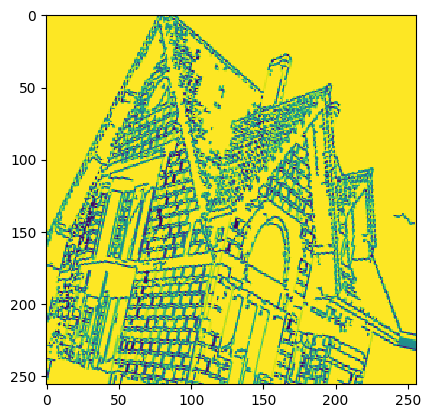

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.image_utils import img_to_array
from matplotlib import pyplot as plt

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=.1,
    shear_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest',
)

image_query_ = cv2.cvtColor(image_query, cv2.COLOR_BGR2GRAY)
image_query_ = cv2.resize(image_query_, image_size)

image_query_arr = img_to_array(image_query_)  # this is a Numpy array with shape (3, 150, 150)
image_query_arr = image_query_arr.reshape((1,) + image_query_arr.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
print(image_query_arr.shape)
dataset_query = []

i = 0
for batch in datagen.flow(
    image_query_arr, 
    batch_size=1,
):
    # print(len(batch), batch[0].shape)
    # print(batch[0][0])
    dataset_query.append(batch[0])

    i += 1
    if i > 40:
        break

dataset_query = np.array(dataset_query)
print(dataset_query.shape)
plt.imshow(dataset_query[0], interpolation='nearest')
plt.show()

# for i in dataset_query[0]:
#     print(list(i.tolist()))

(153, 256, 256, 1)


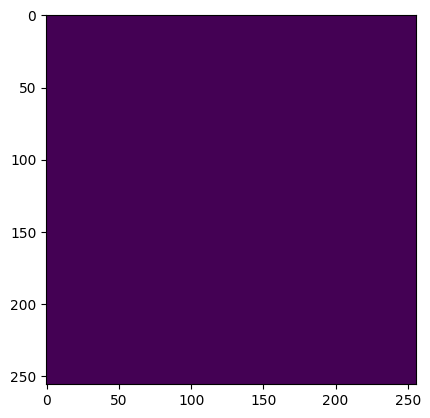

In [ ]:
def image_target_iter(image_target):
    step = 100

    for i in range(0, image_target.shape[0], step):
        for j in range(0, image_target.shape[1], step):
            sub_image = image_target[i: i+image_size[0], j:j+image_size[1]]

            if sub_image.shape[0] != image_size[0] or sub_image.shape[1] != image_size[1]:
                break

            yield sub_image


image_target_ = cv2.cvtColor(image_target, cv2.COLOR_BGR2GRAY)
image_target_ = image_target_ / 255.0

dataset_target = []
for img_ in image_target_iter(image_target_):
    img_ = cv2.resize(img_, image_size)
    dataset_target.append(img_to_array(img_))

dataset_target = np.array(dataset_target)
print(dataset_target.shape)
plt.imshow(dataset_target[0], interpolation='nearest')
plt.show()

# for i in dataset_target[0]:
#     print(list(i.tolist()))

In [ ]:
import itertools
from sklearn.preprocessing import MinMaxScaler


dataset_positive = np.array(list(itertools.combinations(dataset_query, 2)))
dataset_negative = np.array(list(itertools.product(dataset_query[:10], dataset_target)))

print(dataset_positive.shape, dataset_negative.shape)
dataset = np.concatenate((dataset_positive, dataset_negative), axis=0)
dataset = 1 - dataset
dataset = dataset.astype('float16')
print('Min: %.3f, Max: %.3f' % (dataset.min(), dataset.max()))
# scaler = MinMaxScaler()
# scaler.fit(dataset)
# dataset = scaler.transform(dataset)

print(dataset.shape)

y_positive = np.ones(dataset_positive.shape[0], dtype=int)
y_negative = np.zeros(dataset_negative.shape[0], dtype=int)
print(y_positive.shape, y_negative.shape)
y = np.concatenate((y_positive, y_negative), axis=0)
print(y.shape)


(820, 2, 256, 256, 1) (1530, 2, 256, 256, 1)
Min: 0.000, Max: 1.000
(2350, 2, 256, 256, 1)
(820,) (1530,)
(2350,)


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda
from keras import backend as K


def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(8, (5, 5), strides=(3, 3), activation='relu')(input)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(16, (5, 5), strides=(1, 1), activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(128, activation='softmax')(x)
    x = Dropout(0.5)(x)
    model = Model(input, x)
    return model


def get_model():
    input_shape = image_size + (1,)
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    base_network = create_base_network(input_shape)
    left_output = base_network(left_input)
    right_output = base_network(right_input)

    distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([left_output, right_output])

    siamese_net = Model(inputs=[left_input, right_input], outputs=distance)
    print(siamese_net.summary())
    siamese_net.compile(optimizer='adam', loss= 'mse')

    return siamese_net

model = get_model()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           (None, 128)          134624      ['input_4[0][0]',                
                                                                  'input_5[0][0]']          

In [ ]:
print(np.any(np.isnan(dataset)))
print(np.any(np.isnan(y)))
class_weight = {0: 1, 1: 10}

model.fit([dataset[:, 0], dataset[:, 1]], y, epochs=20, batch_size=256, shuffle=True, verbose=True, class_weight=class_weight)

False
False
Epoch 1/20
10/10 [==============================] - 25s 2s/step - loss: 1.6122
Epoch 2/20
10/10 [==============================] - 21s 2s/step - loss: 0.8954
Epoch 3/20
10/10 [==============================] - 23s 2s/step - loss: 0.8593
Epoch 4/20
10/10 [==============================] - 24s 2s/step - loss: 0.8194
Epoch 5/20
10/10 [==============================] - 23s 2s/step - loss: 0.7921
Epoch 6/20
10/10 [==============================] - 21s 2s/step - loss: 0.7937
Epoch 7/20
10/10 [==============================] - 21s 2s/step - loss: 0.8139
Epoch 8/20
10/10 [==============================] - 22s 2s/step - loss: 0.7552
Epoch 9/20
10/10 [==============================] - 20s 2s/step - loss: 0.8109
Epoch 10/20
10/10 [==============================] - 22s 2s/step - loss: 0.7927
Epoch 11/20
10/10 [==============================] - 20s 2s/step - loss: 0.8542
Epoch 12/20
10/10 [==============================] - 22s 2s/step - loss: 0.8075
Epoch 13/20
10/10 [==================

In [ ]:
print(dataset[0][0].shape)
print(dataset[0][1].shape)

a = model.predict([dataset[:10, 0], dataset[:10, 1]])
print(a)

(256, 256, 1)
(256, 256, 1)
1/1 [==============================] - 0s 186ms/step
[[0.06000009]
 [0.07078773]
 [0.07373974]
 [0.06723882]
 [0.06703288]
 [0.0565364 ]
 [0.04290713]
 [0.07833198]
 [0.04606611]
 [0.07623828]]
